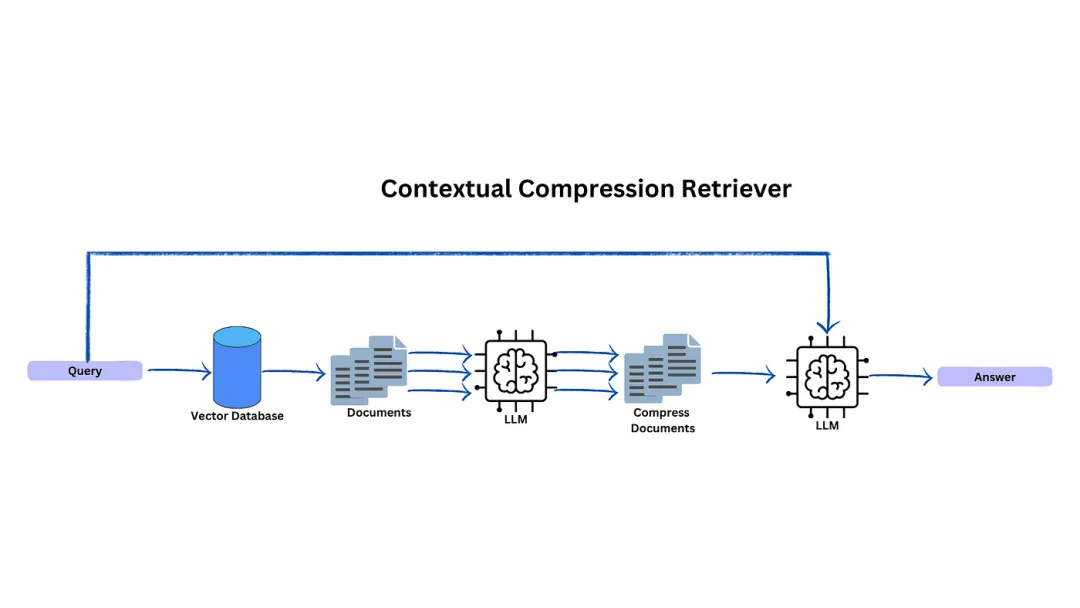

在某些情况下，我们的向量数据库中的每个块中的令牌数量都很高，并且每个块有时会包含一些不相关的信息。为了使LLM能够正确地进行总结，我们需要使用LLM从检索到的文档中删除那些不相关的段落。Langchain提供了上下文压缩文档技术来解决该问题。

代码如下所示：

In [1]:
!pip install langchain langchain_community openai chromadb tiktoken langchainhub sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.1/324.1 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.2/310.2 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 733.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [2]:
# 设置OpenAI KEY环境变量
import os
import getpass
os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key:')

OpenAI API Key:··········


In [3]:
#-------------------------------Prepare Vector Database----------------------
# Build a sample vectorDB
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
import os

# Load blog post
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
data = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
splits = text_splitter.split_documents(data)

# VectorDB
embedding = OpenAIEmbeddings()
vectordb = Chroma.from_documents(documents=splits, embedding=embedding)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [4]:
#----------------------------Contextual Compression Setup---------------------
from langchain.retrievers.document_compressors import DocumentCompressorPipeline, EmbeddingsFilter
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.document_transformers import EmbeddingsRedundantFilter
from langchain.retrievers import ContextualCompressionRetriever

splitter = CharacterTextSplitter(chunk_size=300, chunk_overlap=0, separator=". ")
redundant_filter = EmbeddingsRedundantFilter(embeddings=embedding)
relevant_filter = EmbeddingsFilter(embeddings=embedding, similarity_threshold=0.76)
pipeline_compressor = DocumentCompressorPipeline(
    transformers=[splitter, redundant_filter, relevant_filter]
)

compression_retriever = ContextualCompressionRetriever(
    base_compressor=pipeline_compressor, base_retriever=vectordb.as_retriever()
)

In [5]:
#--------------------------------QnA Part------------------------------------
from langchain.chat_models import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate

llm = ChatOpenAI()

qa_system_prompt = """
        Use the following pieces of retrieved context to answer the question. \
        If you don't know the answer, just say that you don't know. \

        {context}"""

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", qa_system_prompt),
        ("human", "{question}"),
    ]
)

def format_docs(docs):
    doc_strings = [doc.page_content for doc in docs]
    return "\n\n".join(doc_strings)


rag_chain = (
    {"context": compression_retriever | format_docs, "question": RunnablePassthrough()}
    | qa_prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What are the approaches to Task Decomposition?")

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


'The approaches to Task Decomposition include:\n1. Using LLM with simple prompting for subgoals.\n2. Providing task-specific instructions for decomposition.\n3. Involving human inputs in the decomposition process.'